In [253]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

In [254]:
df = pd.read_excel('/kaggle/input/dataset/_.xlsx')

Разделим данные на тест и трейн

In [255]:
train = df.iloc[:, [0, 1, 2] + list(np.arange(11, 97))]
test = df.iloc[:, list(np.arange(11))]

### 1)Бейзлайн - seasonal naive

Т.к. данные имеют недельную сезонность, попробуем наивный подход. 
Будем брать значение недельной давности(если прогнозируем для вторника, то берем значение с прошлого вторника)

In [256]:
day2label = { 'Sunday': 7, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
month2label = {'January': 1, 'February' : 2,  'March' : 3, 'April' : 4, 'May': 5, 'June': 6, 'July' : 7, 
                   'August' : 8,  'September': 9, 'October' : 10, 'November': 11, 'December': 12}

In [257]:
def create_feature(df, station) -> pd.DataFrame:
        
    date = df[df['Станция'] == station].columns[3:]
    count_pass = df[df['Станция'] == station].iloc[0][3:].values
    data = pd.DataFrame(columns=['date', 'day', 'month', 'count_pass'])
    data['date'] = date.astype('datetime64[ns]')
    data['day'] = [day2label[d.strftime("%A")] for d in df.columns[3:]]
    data['month'] = [month2label[d.strftime("%B")] for d in df.columns[3:]]
    data['count_pass'] = count_pass
    data['weekend'] = [1 if d.strftime("%A") in ['Sunday', 'Saturday'] else 0 for d in df.columns[3:]]
    
    return data


def create_dict(data):
    day2pass = { 1 : [], 2 : [], 3 : [], 4 : [], 5 : [], 6 : [], 7 : [] }
    
    for day_of_week in day2pass:
        count_pass = data[data['day'] == day_of_week]['count_pass'].values
        day2pass[day_of_week] = count_pass
        
    return day2pass   

In [258]:
class snaiveModel():
    def __init__(self, stations):
        self.stations = stations
        self.data_predict = {}        
    
    def fit(self, df, method='median', num_last=3, alpha=0.3):
        for station in self.stations:
            data = create_feature(df, station)
            day2pass = create_dict(data)
            self.data_predict[station] = {}
            for day in day2pass:
                if method == 'median':
                    self.data_predict[station][day] = np.median(day2pass[day])
                if method == 'mean':
                    self.data_predict[station][day] = np.mean(day2pass[day])
                if method == 'last':
                    self.data_predict[station][day] = np.mean(day2pass[day][:num_last])
                if method == 'exp':
                    series = day2pass[day][::-1]
                    result = [series[0]]
                    for n in range(1, len(series)):
                        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
                        self.data_predict[station][day] = result[-1]
                    
    def predict(self, station : str, date : datetime) -> int:
        day = date.strftime("%A")
        return self.data_predict[station][day2label[day]]

In [259]:
model = snaiveModel(df['Станция'])
model.fit(train, method='median', num_last=4)

In [260]:
def MAPE(model, test):
    
    error = []
    for station in test['Станция']:
        y_pred = []
        
        for day in test[test['Станция'] == station].columns[3:]:
            y_pred.append(model.predict(station, day))
         
        y_true = test[test['Станция'] == station].values[0][3:]
        
        error.append(mean_absolute_percentage_error(y_true, y_pred))
        #error.append(mean_absolute_error(y_true, y_pred))
        
    return error

In [261]:
min(MAPE(model, test)), max(MAPE(model, test)), np.mean(MAPE(model, test))

(0.2093305498533774, 2.92813803167171, 0.9628622070100008)

### 2) Linear regression

In [262]:
import copy
from sklearn.linear_model import LinearRegression

In [263]:
class LinearModel():
    def __init__(self, stations):
        self.models = {}
        self.stations = stations

    def fit(self, df, num_last=4):
        self.num_last = num_last
        self.df = df
        for station in self.stations:
            model = LinearRegression()
            df_train = create_feature(train, self.stations)
            day2pass = create_dict(df_train)
            
            X_train, y_train = df_train[['day', 'month', 'weekend']], df_train['count_pass']    
            added_features = [list(day2pass[day][(i // 7) : min(len(day2pass[day]), (i // 7) + num_last)]) for (i, day) in enumerate(X_train['day'])][:44]
            
            for (i, feat) in enumerate(added_features):
                added_features[i] = list((np.array(feat) - np.mean(feat)) / np.var(feat)**(1/2))
            
            #print(added_features)
            name_added_features = [f'feature_{i}' for i in range(1, num_last + 1)]
            added_df = pd.DataFrame(added_features, columns=name_added_features)
            
            x_train = pd.concat([X_train, added_df], axis=1, join='inner')[:44]
            
            model.fit(x_train, y_train[:44])
            self.models[station] = copy.deepcopy(model)
    
    def predict(self, station : str, date : datetime) -> int:
        df_train = create_feature(self.df, self.stations)
        day2pass = create_dict(df_train)
        
        data = pd.DataFrame([[0, 0, 0]], columns=['day', 'month', 'weekend'])
        data['month'] = month2label[date.strftime("%B")]
        data['day'] = day2label[date.strftime("%A")]
        data['weekend'] = 1 if date.strftime("%A") in ['Sunday', 'Saturday'] else 0
     
       
        added_features = day2pass[data['day'].values[0]][:self.num_last].reshape((1, self.num_last))
        for (i, feat) in enumerate(added_features):
            added_features[i] = list((np.array(feat) - np.mean(feat)) / np.var(feat)**(1/2))
        name_added_features = [f'feature_{i}' for i in range(1, self.num_last + 1)]
        added_df = pd.DataFrame(added_features, columns=name_added_features)
        
        
        x_train = pd.concat([data, added_df], axis=1, join='inner')
        output = self.models[station].predict(x_train)
        return output

In [264]:
linear_model = LinearModel(df['Станция'])
linear_model.fit(train)

In [265]:
res = MAPE(linear_model, test)
min(res), max(res), np.mean(res)

(0.2383978240240258, 2.622830305210946, 0.8613594763141611)

### 3) Gradient Boosting

In [266]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta

In [267]:
def create_dataset(num_last, train, station):
    df_train = create_feature(train, station)
    first_day = df_train['date'].iloc[-1]
    day2pass = create_dict(df_train)
    num_last_days = num_last*7
    df_train = df_train.iloc[:-num_last_days]


    X_train_df = []
    y_train = []

    for date in train.iloc[0].index[3:-num_last_days]:
        num_week = 12 - (date - first_day).days // 7 

        data = pd.DataFrame([[0, 0, 0]], columns=['day', 'month', 'weekend'])
        data['month'] = month2label[date.strftime("%B")]
        data['day'] = day2label[date.strftime("%A")]
        data['weekend'] = 1 if date.strftime("%A") in ['Sunday', 'Saturday'] else 0

        added_features = day2pass[data['day'].values[0]][num_week: num_week + num_last].reshape((1, num_last))
        name_added_features = [f'feature_{i}' for i in range(1, num_last + 1)]
        added_df = pd.DataFrame(added_features, columns=name_added_features)
        x_train = pd.concat([data, added_df], axis=1, join='inner')

        X_train_df.append(list(x_train.values[0]))
        y_train.append(df_train[df_train['date'] == date]['count_pass'].values[0])
        

    tr = pd.DataFrame(X_train_df, columns=x_train.columns)
    
    return (tr, y_train)

In [268]:
class boosting():
    def __init__(self, stations):
        self.models = {}
        self.stations = stations

    def fit(self, df, num_last=3):
        self.num_last = num_last
        self.df = df 
        for (i, station) in enumerate(self.stations):
            model = GradientBoostingRegressor(n_estimators=80, max_depth=2)
        
            x_train, y_train = create_dataset(self.num_last, df, station)
            model.fit(x_train, y_train)
            self.models[station] = copy.deepcopy(model)
            
            if (i % 20 == 0):
                print(i,'/', len(self.stations), 'current station:', station)
    
    def predict(self, station : str, date : datetime) -> int:
        df_train = create_feature(self.df, self.stations)
        day2pass = create_dict(df_train)
        
        data = pd.DataFrame([[0, 0, 0]], columns=['day', 'month', 'weekend'])
        data['month'] = month2label[date.strftime("%B")]
        data['day'] = day2label[date.strftime("%A")]
        data['weekend'] = 1 if date.strftime("%A") in ['Sunday', 'Saturday'] else 0
        
        added_features = day2pass[data['day'].values[0]][:self.num_last].reshape((1, self.num_last))
        name_added_features = [f'feature_{i}' for i in range(1, self.num_last + 1)]
        added_df = pd.DataFrame(added_features, columns=name_added_features)
        
        x_train = pd.concat([data, added_df], axis=1, join='inner')
        output = self.models[station].predict(x_train)
        return output

In [269]:
boost = boosting(df['Станция'])
boost.fit(train)

0 / 322 current station: Б.Рокоссовского
20 / 322 current station: Орехово
40 / 322 current station: Киевская АПЛ
60 / 322 current station: Пионерская
80 / 322 current station: Площадь Ильича
100 / 322 current station: Новые Черёмушки
120 / 322 current station: Полежаевская
140 / 322 current station: Тульская
160 / 322 current station: Ул. Ак. Янгеля
180 / 322 current station: Достоевская
200 / 322 current station: Шелепиха МЦК
220 / 322 current station: Ботан. сад МЦК
240 / 322 current station: Минская
260 / 322 current station: Мичурин.пр-тСолЛ
280 / 322 current station: Нижегородская
300 / 322 current station: Давыдково
320 / 322 current station: Физтех


In [270]:
res = MAPE(boost, test)
min(res), max(res), np.mean(res), np.median(res)

(0.21290105328480577,
 4.175576541769177,
 0.9483241910000509,
 0.7498389151410269)

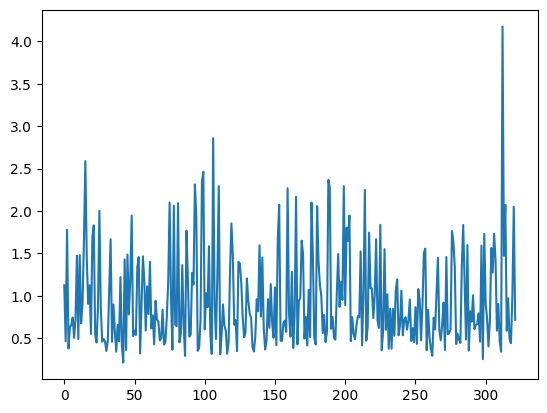

In [271]:
plt.plot(np.arange(len(res)), res)